## Import

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
# import statsmodels.api as sm
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Network

In [105]:
class ARNet(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.w = nn.Linear(p,1,bias=False)
    
    def forward(self, x):
        y = self.w(x)
        return y

## Loss ftn

$$

\min_{\theta} L(y, \hat{y}, \theta) + \lambda(s) \cdot R(\theta) \\

\lambda(s) = c_{\lambda} \cdot \left( s^{-1} - 1 \right) \\
$$

$$
R(\theta) = \frac{1}{p} \sum_{i=1}^{p} \frac{2}{1 + \exp\left(-c_1 \cdot \left| \theta_i \right|^{\frac{1}{c_2}}\right)} - 1
$$

- $s = \frac{\hat{p}_{data}}{p_{model}}$ : AR 계수의 희소성의 기댓값 • 원하는 희소성 정도로 연구자가 설정하는 하이퍼 파라미터다. 

- $c_{\lambda} \approx \frac{\sqrt{\hat{L}}}{100}$ : 규제의 세기로, 추정된 잔차에 비례한다.  


In [134]:
def regulated_mse_loss(pred, y, model, s, c_lam, c1, c2):
    mse_loss = F.mse_loss(pred, y)

    lamb = c_lam * (1/s - 1)
 
    R_theta = torch.mean(2 / (1 + torch.exp(torch.abs(model.w.weight)**(1/c2) * c1))) - 1

    total_loss = mse_loss + lamb * R_theta

    return total_loss

In [144]:
class RegulatedMSELoss:
    def __init__(self, s, c_lam, c1, c2):
        self.s = s
        self.c_lam = c_lam
        self.c1, self.c2 = c1, c2

    def __call__(self, pred, y, model):
        mse_loss = F.mse_loss(pred, y)

        lamb = self.c_lam * (1/self.s - 1)
    
        R_theta = torch.mean(2 / (1 + torch.exp(torch.abs(model.w.weight)**(1/self.c2) * self.c1))) - 1

        total_loss = mse_loss + lamb * R_theta

        return total_loss

## Dataset

In [238]:
def create_dataset(time_series : pd.core.series.Series, lookback : int):
    X, y = [], []

    for i in range(lookback, len(time_series)):
        X.append(time_series.iloc[i - lookback : i])
        y.append(time_series.iloc[i])
    
    return np.array(X).reshape(-1,lookback), np.array(y)

In [59]:
class SeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

## Train

In [145]:
def train(epochs, model, train_loader, loss_ftn, optim, sparse=False):

    loss_list = []

    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            pred = model(X_batch)
            loss = loss_ftn(pred, y_batch) if sparse == False else loss_ftn(pred, y_batch, model)
            total_loss += loss.item()

            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % max(1, epochs // 10) == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
        
        loss_list.append(total_loss/len(train_loader))

    return loss_list

## Test

$$
sTPE = 100 \cdot \frac{\sum_{i=1}^{p} |\hat{w}_i - w_i|}{\sum_{i=1}^{p} |\hat{w}_i| + |w_i|}
$$

In [149]:
def test(model, test_loader, loss_ftn):
    total_loss = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            loss = loss_ftn(pred, y_batch)
            total_loss.append(loss.item())

    print(f"loss : {np.mean(total_loss):3f}")

In [166]:
def plot_predictions(forward_dataset, model):
    # 예측값과 실제값 리스트 분리
    preds = []
    targets = []

    for x, y in forward_dataset:
        with torch.no_grad():
            pred = model(x)
        preds.append(pred.item())
        targets.append(y.item()) 

    # 시각화
    plt.plot(targets, label="True")
    plt.plot(preds, label="Predicted", linestyle="--", color='r')
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Prediction vs Ground Truth")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [169]:
def plot_weights(model):
    weights = model.w.weight.reshape(-1).clone().detach().cpu().numpy()

    # 바 그래프 그리기
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(weights)), weights)
    plt.xlabel("AR Coefficient Index")
    plt.ylabel("Value")
    plt.title("Learned AR Coefficients (Sparse Regularization)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main

## AirPassengers

### Preprocessing

In [ ]:
# AirPassengers Data
data = sm.datasets.get_rdataset("AirPassengers").data

In [ ]:
# 연도와 월 추출
data['year'] = data['time'].astype(int)
data['month'] = ((data['time'] - data['year']) * 12 + 1).round().astype(int)

# datetime 형식의 Month 컬럼 생성 -> index 
data['Month'] = pd.to_datetime(dict(year=data['year'], month=data['month'], day=1))
data.set_index('Month', inplace=True)

# 확인
print(data[['year', 'month', 'Month']].head())

            year  month      Month
Month                             
1949-01-01  1949      1 1949-01-01
1949-02-01  1949      2 1949-02-01
1949-03-01  1949      3 1949-03-01
1949-04-01  1949      4 1949-04-01
1949-05-01  1949      5 1949-05-01


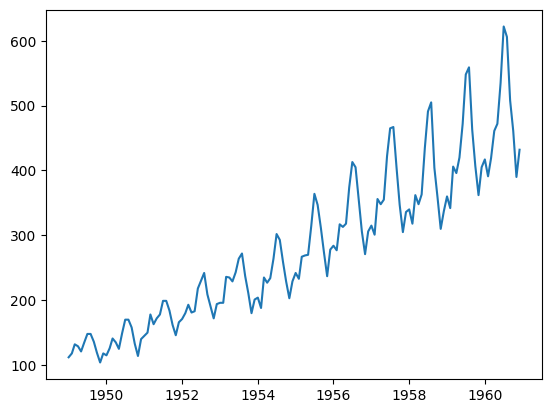

In [ ]:
plt.plot(data['value'])
plt.show()

### p=12

In [171]:
# HYPER PARAMS 
LOOKBACK = 12

EPOCHS = 1000
BATCH_SIZE = 16
LR = 0.001

In [172]:
X, y_target = create_dataset(data.value, LOOKBACK)

print("X shape:", X.shape) 
print("y shape:", y_target.shape) 

X shape: (132, 12)
y shape: (132,)


In [173]:
# split dataset into train-test (8:2)
X_train, X_test, y_train, y_test = train_test_split( X, y_target, test_size=0.2, shuffle=True )

print(y_train.shape, y_test.shape)

(105,) (27,)


In [174]:
# define Dataset & DataLoader
train_dataset = SeriesDataset(X_train, y_train)
test_dataset = SeriesDataset(X_test, y_test)
forward_dataset = SeriesDataset(X, y_target)

# Dataset -> DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [175]:
# model, loss, optim 
model = ARNet(p=LOOKBACK)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# train - test 
loss_list = train(EPOCHS, model, train_loader, criterion, optimizer)
test(model, test_loader, criterion)

Epoch [1/1000], Loss: 122182.3136
Epoch [100/1000], Loss: 3825.8777
Epoch [200/1000], Loss: 1942.1838
Epoch [300/1000], Loss: 968.9383
Epoch [400/1000], Loss: 573.3754
Epoch [500/1000], Loss: 373.1629
Epoch [600/1000], Loss: 331.7689
Epoch [700/1000], Loss: 306.4006
Epoch [800/1000], Loss: 282.2713
Epoch [900/1000], Loss: 261.5879
Epoch [1000/1000], Loss: 259.9870
loss : 147.216278


In [176]:
p_12 = (model.w.weight).reshape(-1).clone().detach()

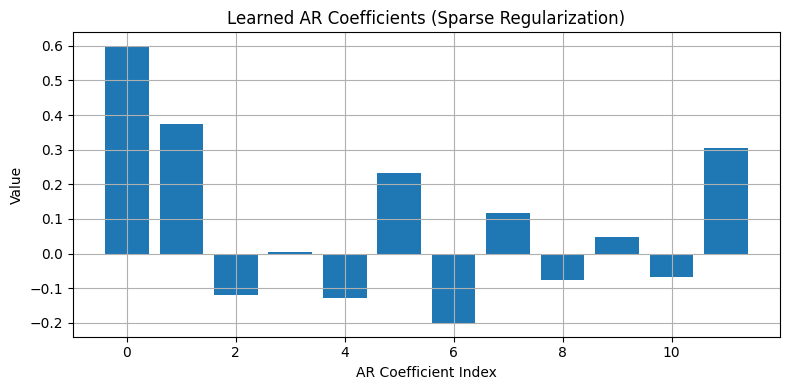

In [177]:
plot_weights(model)

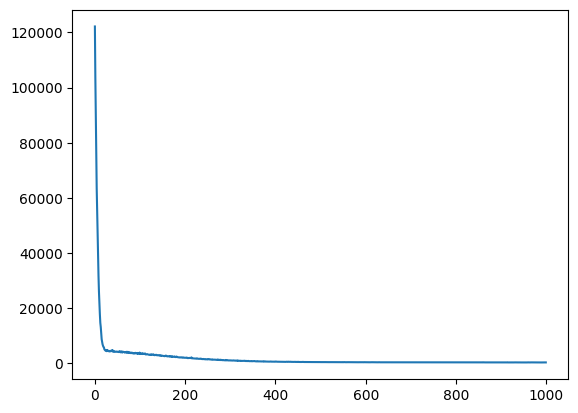

In [178]:
plt.plot(loss_list)
plt.show()

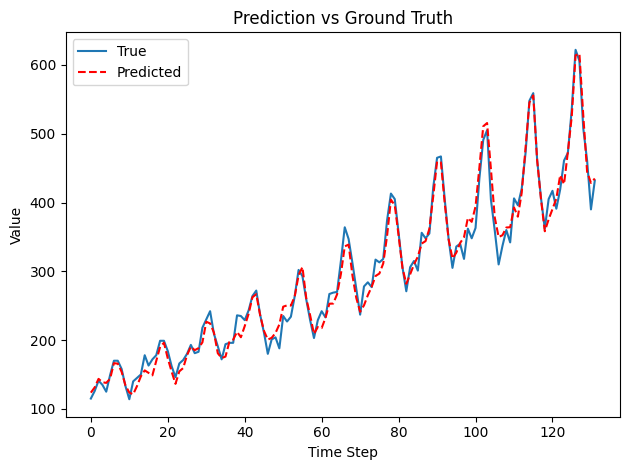

In [179]:
plot_predictions(forward_dataset, model)

### p=30

In [200]:
# HYPER PARAMS 
LOOKBACK = 50

EPOCHS = 1000
BATCH_SIZE = 16
LR = 0.001

In [201]:
X, y_target = create_dataset(data.value, LOOKBACK)

print("X shape:", X.shape) 
print("y shape:", y_target.shape) 

X shape: (94, 50)
y shape: (94,)


In [202]:
# split dataset into train-test (8:2)
X_train, X_test, y_train, y_test = train_test_split( X, y_target, test_size=0.2, shuffle=True )

print(y_train.shape, y_test.shape)

(75,) (19,)


In [203]:
# define Dataset & DataLoader
train_dataset = SeriesDataset(X_train, y_train)
test_dataset = SeriesDataset(X_test, y_test)
forward_dataset = SeriesDataset(X, y_target)

# Dataset -> DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
# model, loss, optim 
model = ARNet(p=LOOKBACK)
criterion = RegulatedMSELoss(s=0.03, c_lam=0.01, c1=30., c2=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# train - test 
loss_list = train(EPOCHS, model, train_loader, criterion, optimizer, sparse=True)
test(model, test_loader, nn.MSELoss())

Epoch [1/1000], Loss: 12811.1348
Epoch [100/1000], Loss: 550.2596
Epoch [200/1000], Loss: 281.4919
Epoch [300/1000], Loss: 248.7464
Epoch [400/1000], Loss: 188.9549
Epoch [500/1000], Loss: 189.0529
Epoch [600/1000], Loss: 165.2783
Epoch [700/1000], Loss: 163.6983
Epoch [800/1000], Loss: 160.8482
Epoch [900/1000], Loss: 129.4507
Epoch [1000/1000], Loss: 134.6254
loss : 154.238190


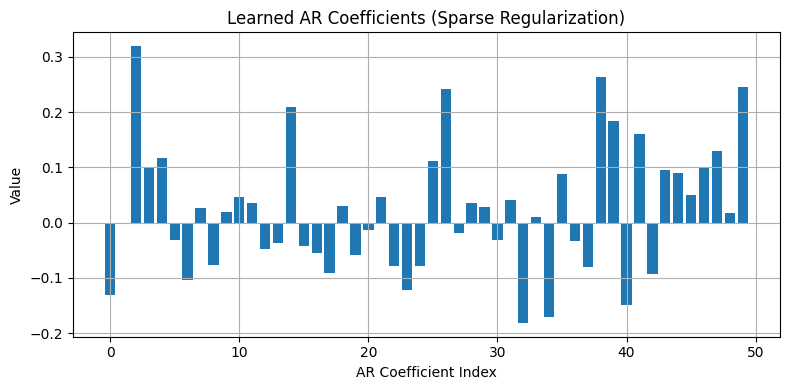

In [205]:
plot_weights(model)

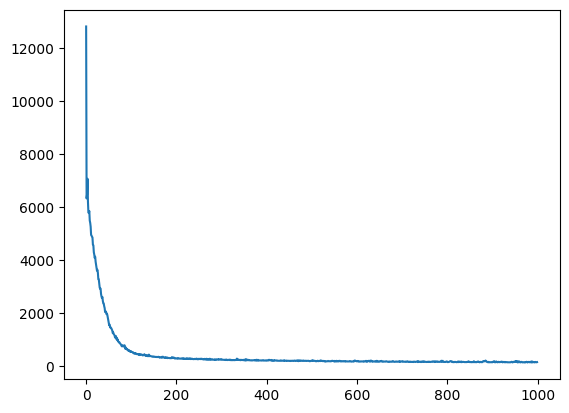

In [206]:
plt.plot(loss_list)
plt.show()

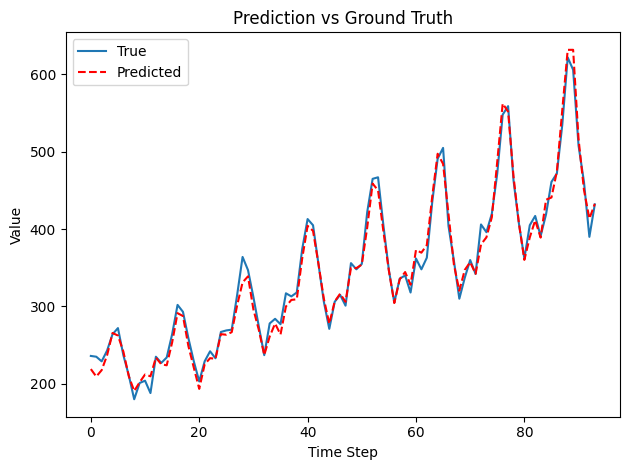

In [207]:
plot_predictions(forward_dataset, model)

## synthetic

In [261]:
def make_synthetic_ar_data(length=200):

    # AR 계수 정의 (p=12)
    phi_dense = np.array([0.4, -0.2, 0.1, 0.1, -0.1, 0.05, -0.02, 0.01, 0.05, 0.05, 0.05, -0.05])
    phi_sparse = np.array([0.3, 0.0, 0.0, -0.2, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.15, 0.0])

    # 잡음
    epsilon = np.random.normal(0, .1, size=length)

    # 시계열 생성 함수
    def generate_ar_series(phi, noise):
        y = np.zeros_like(noise)
        for t in range(len(phi), len(y)):
            y[t] = np.dot(phi, y[t - len(phi):t][::-1]) + noise[t]
        return y

    # 시계열 생성
    y_dense = generate_ar_series(phi_dense, epsilon.copy())
    y_sparse = generate_ar_series(phi_sparse, epsilon.copy())

    return y_dense, y_sparse

In [262]:
y_dense, y_sparse = make_synthetic_ar_data(2000)

### p=12

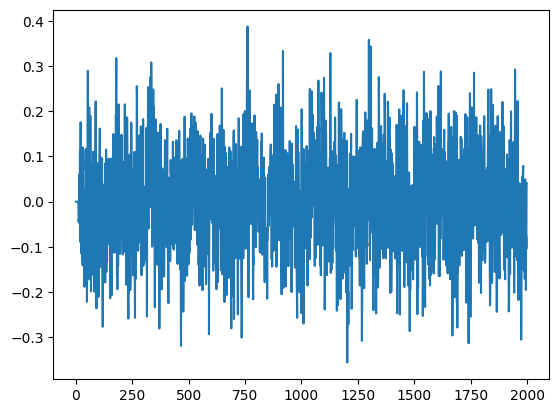

In [263]:
plt.plot(y_sparse)
plt.show()

### p=12

In [289]:
# HYPER PARAMS 
LOOKBACK = 12

EPOCHS = 1000
BATCH_SIZE = 16
LR = 0.001

In [290]:
X, y_target = create_dataset(pd.DataFrame(y_sparse), LOOKBACK)

print("X shape:", X.shape) 
print("y shape:", y_target.shape) 

X shape: (1988, 12)
y shape: (1988, 1)


In [291]:
# split dataset into train-test (8:2)
X_train, X_test, y_train, y_test = train_test_split( X, y_target, test_size=0.2, shuffle=True )

print(y_train.shape, y_test.shape)

(1590, 1) (398, 1)


In [292]:
# define Dataset & DataLoader
train_dataset = SeriesDataset(X_train, y_train)
test_dataset = SeriesDataset(X_test, y_test)
forward_dataset = SeriesDataset(X, y_target)

# Dataset -> DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [293]:
# model, loss, optim 
model = ARNet(p=LOOKBACK)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# train - test 
loss_list = train(EPOCHS, model, train_loader, criterion, optimizer)
test(model, test_loader, criterion)

Epoch [1/1000], Loss: 0.0149
Epoch [100/1000], Loss: 0.0129
Epoch [200/1000], Loss: 0.0129
Epoch [300/1000], Loss: 0.0129
Epoch [400/1000], Loss: 0.0128
Epoch [500/1000], Loss: 0.0128
Epoch [600/1000], Loss: 0.0128
Epoch [700/1000], Loss: 0.0129
Epoch [800/1000], Loss: 0.0128
Epoch [900/1000], Loss: 0.0129
Epoch [1000/1000], Loss: 0.0129
loss : 0.011672


In [294]:
p_12 = (model.w.weight).reshape(-1).clone().detach()

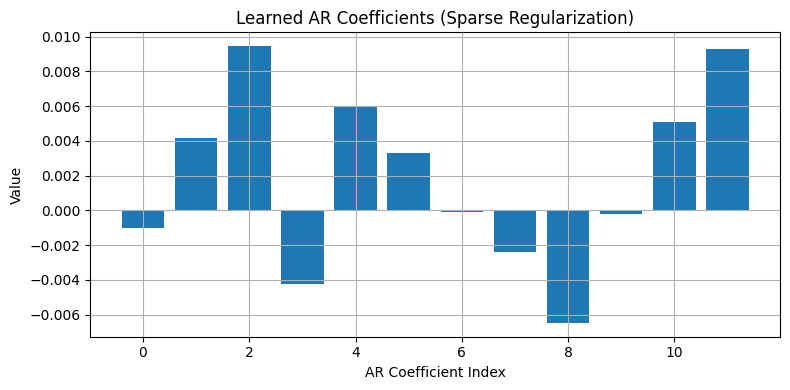

In [295]:
plot_weights(model)

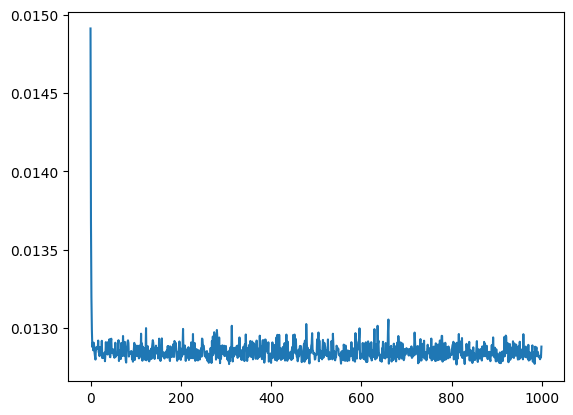

In [296]:
plt.plot(loss_list)
plt.show()

### p=30

In [281]:
# HYPER PARAMS 
LOOKBACK = 50

EPOCHS = 1000
BATCH_SIZE = 16
LR = 0.001

In [282]:
X, y_target = create_dataset(pd.DataFrame(y_sparse), LOOKBACK)

print("X shape:", X.shape) 
print("y shape:", y_target.shape) 

X shape: (1950, 50)
y shape: (1950, 1)


In [283]:
# split dataset into train-test (8:2)
X_train, X_test, y_train, y_test = train_test_split( X, y_target, test_size=0.2, shuffle=True)

print(y_train.shape, y_test.shape)

(1560, 1) (390, 1)


In [284]:
# define Dataset & DataLoader
train_dataset = SeriesDataset(X_train, y_train)
test_dataset = SeriesDataset(X_test, y_test)
forward_dataset = SeriesDataset(X, y_target)

# Dataset -> DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [285]:
# model, loss, optim 
model = ARNet(p=LOOKBACK)
criterion = RegulatedMSELoss(s=0.03, c_lam=0.01, c1=30., c2=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# train - test 
loss_list = train(EPOCHS, model, train_loader, criterion, optimizer, sparse=True)
test(model, test_loader, nn.MSELoss())

/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_39157/496011524.py:8: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(pred, y)
/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_39157/496011524.py:8: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(pred, y)


Epoch [1/1000], Loss: -0.2626
Epoch [100/1000], Loss: -0.2897
Epoch [200/1000], Loss: -0.2897
Epoch [300/1000], Loss: -0.2898
Epoch [400/1000], Loss: -0.2899
Epoch [500/1000], Loss: -0.2897
Epoch [600/1000], Loss: -0.2897
Epoch [700/1000], Loss: -0.2898
Epoch [800/1000], Loss: -0.2897
Epoch [900/1000], Loss: -0.2899
Epoch [1000/1000], Loss: -0.2895
loss : 0.027087


/opt/anaconda3/envs/AiGO/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([390, 1, 1])) that is different to the input size (torch.Size([390, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


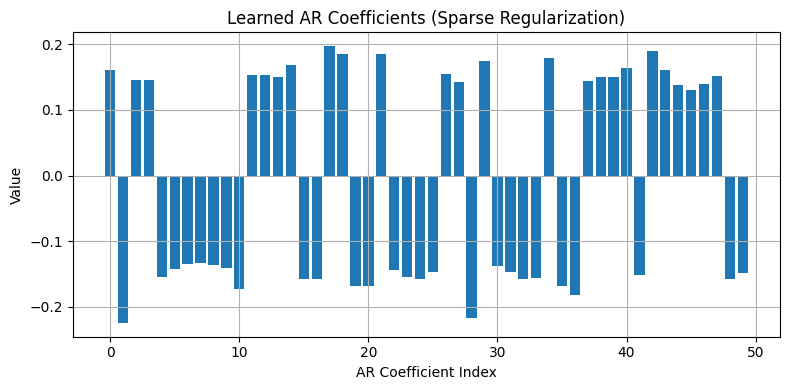

In [286]:
plot_weights(model)

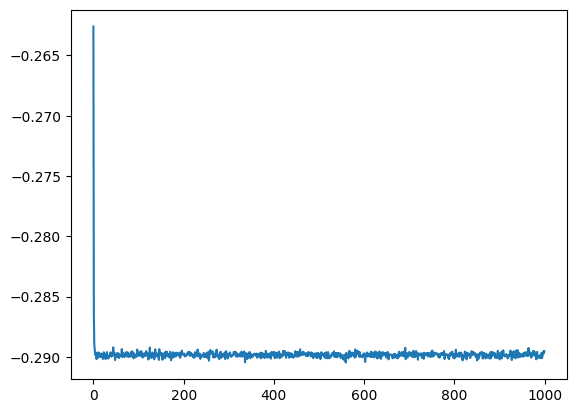

In [287]:
plt.plot(loss_list)
plt.show()

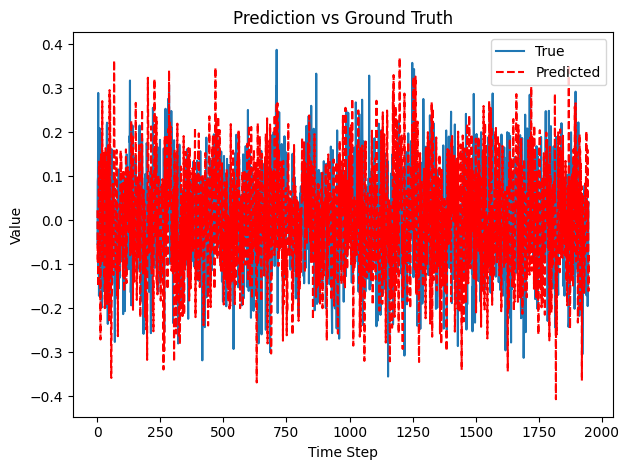

In [288]:
plot_predictions(forward_dataset, model)